<H1>SEP 788 - Project: Lane Detection for Autonomous Vehicles</H1>
<H3>By Group 13</H3>

## Data Description

Data Source: https://xingangpan.github.io/projects/CULane.html
<br>
Paper: Spatial As Deep: Spatial CNN for Traffic Scene Understanding (https://arxiv.org/pdf/1712.06080.pdf)

>CULane is a large scale challenging dataset for academic research on traffic lane detection. It is collected by cameras mounted on six different vehicles driven by different drivers in Beijing. More than 55 hours of videos were collected and 133,235 frames were extracted. The dataset has been divided into 88880 for training set, 9675 for validation set, and 34680 for test set. The test set is divided into normal and 8 challenging categories. For each frame, the traffic lanes were manually annotated. For cases where lane markings are occluded by vehicles or are unseen, the lanes are still annotated according to the context. In this dataset, attention is focussed on the detection of four lane markings, which are paid most attention to in real applications. Other lane markings are not annotated.

## Imports and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive

In [2]:
ROOT_FOLDER = '/content/data' # Directory where data is extracted
SAVE_FOLDER = '/content/drive/My Drive/Models' # Directory where models are saved

# Constants:
IMAGE_SIZE_ORIG = [295, 820] # Original pre-processed image size
IMAGE_SIZE_MODEL = [224, 224] # Resized image size before training
INPUT_SHAPE = [224, 224, 3] # Input shape for the models (Image Size plus 3 channels for RGB)
NUM_CLASSES = 5 # Number of segmentation class labels

# Hyperparameters:
BATCH_SIZE_TRAIN = 64 # Training and validation dataset batch size
LANE_CLASS_WEIGHT = 2.0 # Weight multiplier for the lane class labels to emphasize lane markings as opposed to background, determined empirically, higher weights worsen prediction
EPOCHS = 7 # Number of training epochs

BATCH_SIZE_TEST = 64 # Test dataset batch size
RANDOM_SEED_TRAIN = 47 # Random seed to shuffle training and validation data
RANDOM_SEED_TEST = 33 # Random seed to shuffle testing data
FRACTION_TRAIN = 0.5 # Proportion of available training and validation data to use, reduce to decrease train time
FRACTION_TEST = 0.5 # Proportion of available test data to use, reduce to decrease testing time
FRACTION_METRICS = 0.5 # Proportion of training and validation data to calculate lane accuracy metrics on

# Data Preparation and Pre-Processing

## Extract Data

The processed data was uploaded to Google Drive and then is imported and unzipped below. Note that most pre-processing was done prior to uploading the images to Google Drive. This python code was run separately and shrunk the files enough to fit them on Google Drive.

In [3]:
drive.mount("/content/drive") # Connect to Google Drive

# Extract the preprocessed data zip files from Google Drive to local runtime directory for faster access
# The preprocesses data was divided into 3 zip files to make it easier to upload to Google Drive
print("Extracting File 1")
!unzip -q "/content/drive/My Drive/Data/processed_1.zip" -d "/content/data"
print("Extracting File 2")
!unzip -q "/content/drive/My Drive/Data/processed_2.zip" -d "/content/data"
print("Extracting File 3")
!unzip -q "/content/drive/My Drive/Data/processed_3.zip" -d "/content/data"
print("Data Extraction Complete")

Mounted at /content/drive
Extracting File 1
Extracting File 2
Extracting File 3
Data Extraction Complete


## Data Pre-processing

### Image and Label Reading Pipeline

Due to the quantity and size of images, they could not all be read into RAM at the same time. Therefore, a specific TensorFlow tensor dataset datatype is created where the images will be loaded individually when they are needed. Due to this approach, a pipeline was set up to process the input image and label image as necessary when it is opened. After each image is loaded, each pixel in each channel is standardized from 0-1 and the class image is split apart into onehot encoding. The image and label mask is resized to 224 x 224 as this is the expected size for the optimal performance of most pre-trained U-Net based CNN models such as MobileNetV2, ResNet50 and VGG19.

In [4]:
# Reads the images from the paths and returns the standardized image, one-hot mask encoding, and label weights
def process_path(image_paths, mask_paths):
  image_content = tf.io.read_file(image_paths) # Read image jpg file
  mask_content = tf.io.read_file(mask_paths) # Read mask png file
  image = tf.image.decode_jpeg(image_content, channels=3)
  mask = tf.image.decode_png(mask_content, channels=1)
  image = tf.image.resize(image, IMAGE_SIZE_MODEL, method="lanczos3", antialias=True) # Lanczos3 downsampling better preserves small details
  image = tf.clip_by_value(tf.cast(image, tf.float32)/255, 0.0, 1.0)
  mask = tf.image.resize(mask, IMAGE_SIZE_MODEL, method="nearest") # Nearest downsapling avoids floating point values
  mask = tf.one_hot(tf.squeeze(mask), NUM_CLASSES) # Convert mask to one-hot encoding

  weights = np.full(NUM_CLASSES, LANE_CLASS_WEIGHT, dtype=np.float32) # Set lane marking classes weight to LANE_CLASS_WEIGHT
  weights[0] = 1.0 # Set background class weight to 1
  weights = tf.convert_to_tensor(weights)
  weights = weights/tf.reduce_sum(weights) # Normalize weights
  pixel_weights = tf.gather(weights, indices=tf.argmax(mask, axis=-1)) # Create an image of weights by using the label at each pixel as an index into the weights array
  return image, mask, pixel_weights

# Converts the resized image used for training back to the original size
def revert_image(image): 
  image = tf.image.resize(image, IMAGE_SIZE_ORIG, method="lanczos3")
  return tf.clip_by_value(image, 0.0, 1.0)

# Converts the one-hot mask output from the models back to the original size
def revert_one_hot_mask(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = tf.image.resize(tf.expand_dims(mask, -1), IMAGE_SIZE_ORIG, method="nearest")
  return tf.squeeze(mask)

### Prepare Dataset using Paths

There are text files that accompany the dataset. These files contain a listing of all image pairs that make up the dataset. Each line in the text file contains a relative path to the input image, a relative path to the label image and information on which lane markings appear in that photo. These text files are being used to index through and access the images.

In [5]:
# Reads paths from the txt files that accompany the CULane dataset
def read_paths(file_path, fraction, seed):
  paths_df = pd.read_csv(ROOT_FOLDER + file_path, names = ['Image_Path','Label_Path','Marking_1','Marking_2','Marking_3', 'Marking_4'], delim_whitespace=True)
  paths_df['Image_Path'] = ROOT_FOLDER + paths_df['Image_Path'] # Create absolute paths
  paths_df['Label_Path'] = ROOT_FOLDER + paths_df['Label_Path']
  return paths_df.sample(frac=fraction, random_state=seed).reset_index(drop=True) # Shuffle and sample a portion of the data

# Read paths from txt files
train_paths = read_paths('/list/train_gt.txt', FRACTION_TRAIN, RANDOM_SEED_TRAIN)
val_paths = read_paths('/list/val_gt.txt', FRACTION_TRAIN, RANDOM_SEED_TRAIN)
test_paths = read_paths('/list/test_gt.txt', FRACTION_TEST, RANDOM_SEED_TEST)

display(train_paths.head()) # Visualize first few elements

Image_Path  \
0  /content/data/driver_23_30frame/05161223_0545....   
1  /content/data/driver_161_90frame/06032149_0956...   
2  /content/data/driver_161_90frame/06040305_1061...   
3  /content/data/driver_182_30frame/06010910_0115...   
4  /content/data/driver_23_30frame/05160817_0463....   

                                          Label_Path  Marking_1  Marking_2  \
0  /content/data/laneseg_label_w16//driver_23_30f...          1          1   
1  /content/data/laneseg_label_w16//driver_161_90...          0          1   
2  /content/data/laneseg_label_w16//driver_161_90...          0          0   
3  /content/data/laneseg_label_w16//driver_182_30...          0          1   
4  /content/data/laneseg_label_w16//driver_23_30f...          1          1   

   Marking_3  Marking_4  
0          1          1  
1          1          1  
2          0          0  
3          1          1  
4          1          1

In [6]:
# Create tensor datasets of paths
train_ds = tf.data.Dataset.from_tensor_slices((train_paths['Image_Path'], train_paths['Label_Path']))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths['Image_Path'], val_paths['Label_Path']))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths['Image_Path'], test_paths['Label_Path']))

# Map out the pipeline to access the images
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Set up batch access to the dataset
train_batches = train_ds.batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=tf.data.AUTOTUNE)
val_batches = val_ds.batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_ds.batch(BATCH_SIZE_TEST).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f'Number of samples in the training set: {len(train_ds)}')
print(f'Number of samples in the validation set: {len(val_ds)}')
print(f'Number of samples in the testing set: {len(test_ds)}')
print()
print(f'Number of batches in the training set: {len(train_batches)}')
print(f'Number of batches in the validation set: {len(val_batches)}')
print(f'Number of batches in the testing set: {len(test_batches)}')

Number of samples in the training set: 44440
Number of samples in the validation set: 4838
Number of samples in the testing set: 17340

Number of batches in the training set: 695
Number of batches in the validation set: 76
Number of batches in the testing set: 271


# Data Exploration and Visualization

## Class / Label Visualization

Visualize one of the input images after the standardization and the one-hot encoded label images (also referred to as masks) as a sanity check. Finally, overlay the labels on the original image. 

Image shape:  (224, 224, 3)
Mask shape:  (224, 224, 5)
Weights shape:  (224, 224) 



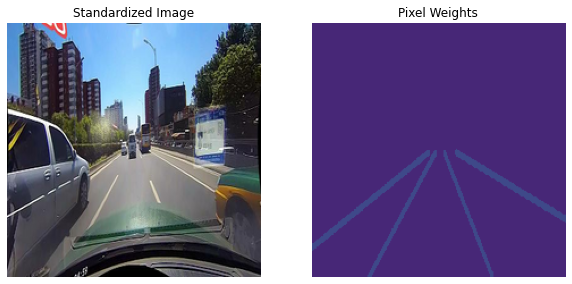

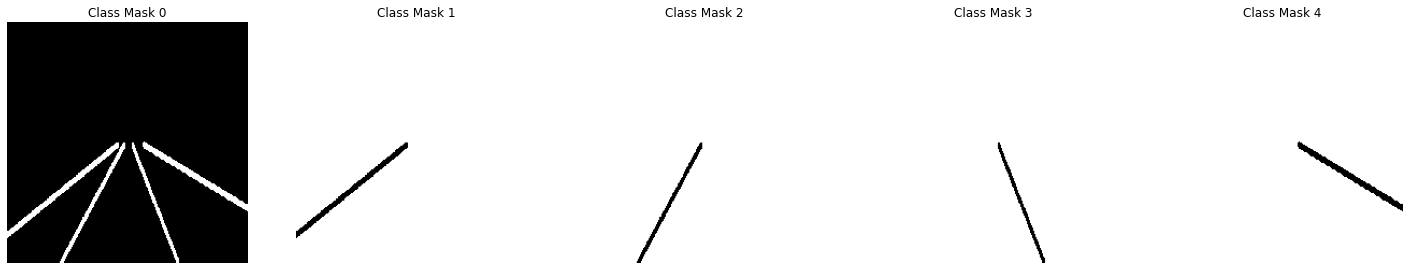


Image shape:  (295, 820, 3)
Mask shape:  (295, 820) 



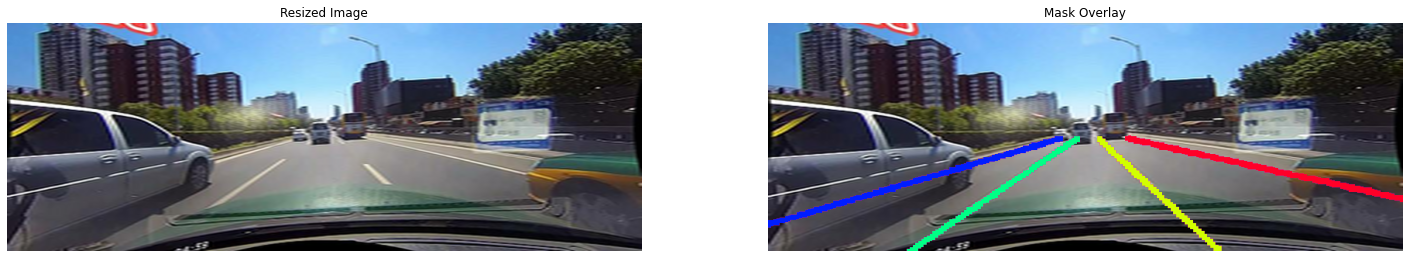

In [7]:
for image, mask, weights in train_ds.take(1):
  sample_image, sample_mask = image, mask
  print("Image shape: ", image.shape)
  print("Mask shape: ", mask.shape)
  print("Weights shape: ", weights.shape, "\n")

  plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(image, vmin=0, vmax=1)
  plt.title('Standardized Image')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(weights, vmin=0, vmax=1)
  plt.title('Pixel Weights')
  plt.axis('off')
  plt.show()
  print()
  
  plt.figure(figsize=(25,10))
  for i in range(NUM_CLASSES):
    plt.subplot(1, NUM_CLASSES, i+1)
    plt.imshow(mask[:,:,i], cmap='binary', vmin=0, vmax=1)
    plt.title(f'Class Mask {i}')
    plt.axis('off')
  plt.show()

  image = revert_image(image).numpy()
  mask = revert_one_hot_mask(mask).numpy()
  print("\nImage shape: ", image.shape)
  print("Mask shape: ", mask.shape, "\n")

  plt.figure(figsize=(25,10))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title('Resized Image')
  plt.axis('off')  
  plt.subplot(1, 2, 2)
  overlay = np.uint8(plt.cm.gist_rainbow_r(mask/4)*255)
  overlay[:,:,3] = (mask != 0).astype(np.int8) * 255 # Set alpha value based on mask
  plt.title('Mask Overlay')
  plt.imshow(image)
  plt.imshow(overlay)
  plt.axis('off')
  plt.show()

## Class / Label Distribution

### Distribution of Datasets

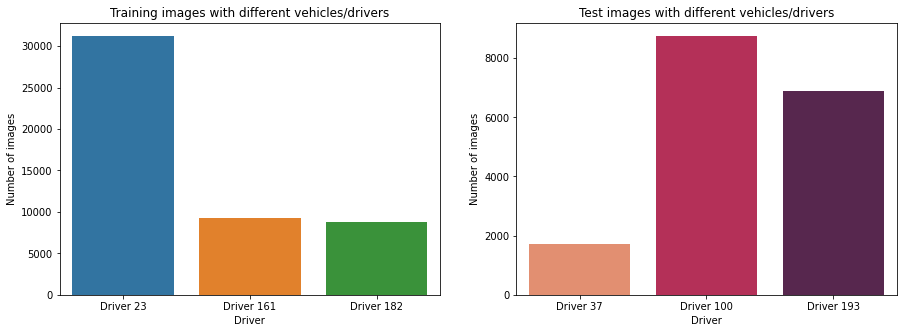

In [10]:
frame23_30 = train_paths['Image_Path'].str.contains('driver_23_30frame').value_counts()[True] + val_paths['Image_Path'].str.contains('driver_23_30frame').value_counts()[True]
frame161_90 = train_paths['Image_Path'].str.contains('driver_161_90frame').value_counts()[True]
frame182_30 = train_paths['Image_Path'].str.contains('driver_182_30frame').value_counts()[True]

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.barplot(x=['Driver 23','Driver 161','Driver 182'], y=[frame23_30, frame161_90, frame182_30])
plt.title('Training images with different vehicles/drivers')
plt.xlabel('Driver')
plt.ylabel('Number of images')
plt.subplot(1, 2, 2)
frame37_30 = test_paths['Image_Path'].str.contains('driver_37_30frame').value_counts()[True]
frame100_30 = test_paths['Image_Path'].str.contains('driver_100_30frame').value_counts()[True]
frame193_90 = test_paths['Image_Path'].str.contains('driver_193_90frame').value_counts()[True]
sns.barplot(x=['Driver 37','Driver 100','Driver 193'], y=[frame37_30, frame100_30, frame193_90], palette="rocket_r")
plt.title('Test images with different vehicles/drivers')
plt.xlabel('Driver')
plt.ylabel('Number of images')
plt.show()

### Distribution of Image Labels

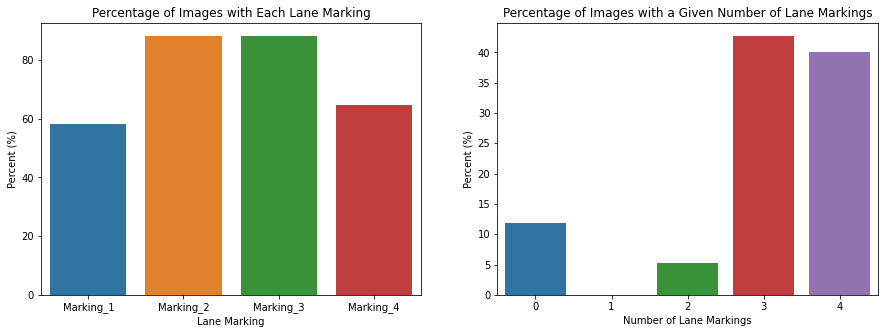

In [11]:
markings_df = pd.concat([train_paths, val_paths], axis = 1).iloc[:,2:6]
num_markings = markings_df.sum(axis=1)
num_markings = num_markings.value_counts()/num_markings.count()
marking_freq = markings_df.mean()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=marking_freq.index, y=marking_freq.values*100)
plt.ylabel('Percent (%)')
plt.xlabel('Lane Marking')
plt.title('Percentage of Images with Each Lane Marking')
plt.subplot(1,2,2)
sns.barplot(x=num_markings.index, y=num_markings.values*100)
plt.title('Percentage of Images with a Given Number of Lane Markings')
plt.xlabel('Number of Lane Markings')
plt.ylabel('Percent (%)')
plt.show()

### Label Spatial Distribution Heatmaps

In [ ]:
heatmap = np.zeros(sample_mask.shape, np.int32)
for image, mask, weights in train_ds:
  heatmap += mask
for image, mask, weights in val_ds:
  heatmap += mask

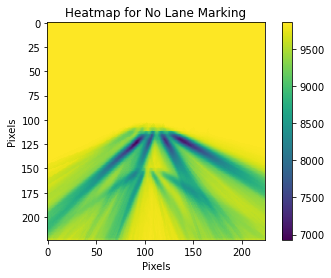

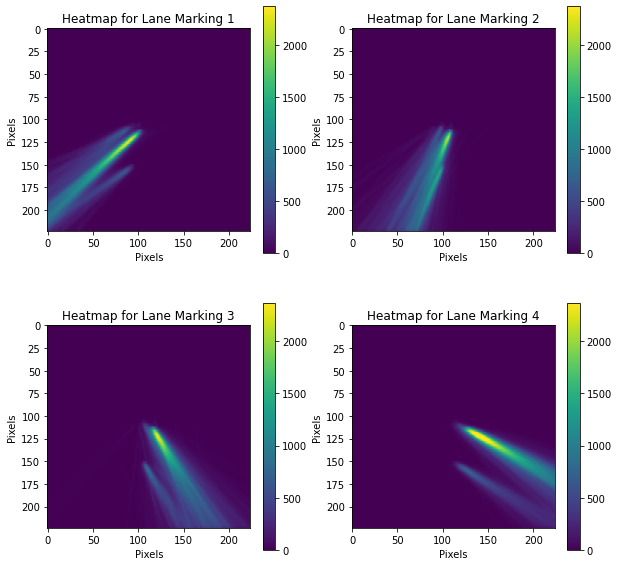

In [ ]:
maxNum = np.max(heatmap[:,:,1:4])
plt.imshow(heatmap[:,:,0])
plt.title(f'Heatmap for No Lane Marking')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()
plt.show()
print()

plt.figure(figsize=(10,10))
for i in range(1,NUM_CLASSES):
  plt.subplot(2, 2, i)
  plt.imshow(heatmap[:,:,i], vmin=0, vmax=maxNum)
  plt.title(f'Heatmap for Lane Marking {i}')
  plt.xlabel('Pixels')
  plt.ylabel('Pixels')
  plt.colorbar()
plt.show()

### Label Distribution by Pixel

Percentage of Image Pixels Belonging to Each Class:
[97.0202016   0.72376524  0.68889246  0.77774225  0.78939846] 



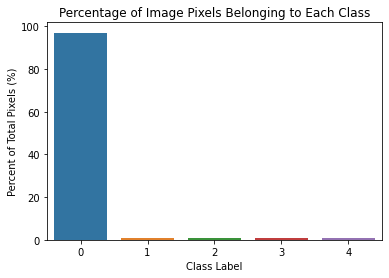

In [ ]:
label_cnt = np.zeros(NUM_CLASSES)
for i in range(NUM_CLASSES):
	label_cnt[i] = np.sum(heatmap[:,:,i])
label_cnt = label_cnt/np.sum(label_cnt)*100
print('Percentage of Image Pixels Belonging to Each Class:')
print(label_cnt, '\n')
sns.barplot(x = np.arange(NUM_CLASSES), y = label_cnt)
plt.title('Percentage of Image Pixels Belonging to Each Class')
plt.xlabel('Class Label')
plt.ylabel('Percent of Total Pixels (%)')
plt.show()

# Model Creation

## Support and Evaluation Functions

### Save and Load Model

In [12]:
# Save trained model and the training history metrics
def save_model_and_history(model_obj, model_history, model_metrics, model_name):
  model_obj.save(SAVE_FOLDER + '/' + model_name)
  hist_df = pd.DataFrame(model_history.history)
  hist_df["epoch"] = model_history.epoch
  hist_df.to_csv(SAVE_FOLDER + '/' + model_name + '/history.csv')
  metrics_df = pd.DataFrame(model_metrics)
  metrics_df.to_csv(SAVE_FOLDER + '/' + model_name + '/metrics.csv')

# Load trained model and the training history metrics
def load_model_and_history(model_name):
  model_obj = tf.keras.models.load_model(SAVE_FOLDER + '/' + model_name)
  hist_df = pd.read_csv(SAVE_FOLDER + '/' + model_name + '/history.csv')
  metrics_df = pd.read_csv(SAVE_FOLDER + '/' + model_name + '/metrics.csv')
  return model_obj, hist_df, metrics_df

### Interpret Lane Markings in Predictions

In [13]:
# Compute lines of best fit for the 4 lane markings from the mask data
def get_line_fit(pred_mask):
  pred_mask = pred_mask.numpy()
  res_mask = np.zeros(pred_mask.shape, np.int32)
  slopes = np.full(NUM_CLASSES-1, 0, dtype=np.float32) # Slopes in image coordinate system with origin at top left corner
  intercepts = np.full(NUM_CLASSES-1, -1, dtype=np.float32) # Intercept on x axis when y = half image height

  # Define the valid ranges of lane lines in 224x224 resized images, determined empirically from the dataset
  slopes_max = [-0.2, -0.6, 100,   2]
  slopes_min = [  -2, -100, 0.6, 0.2]
  intercepts_max = [164, 164, 210, 210] # intercepts on x axis at half image height
  intercepts_min = [ 14,  14,  60,  60]

  for i in range(0, NUM_CLASSES-1):
    num_pixels = np.count_nonzero(pred_mask[:,:,i+1])
    if (num_pixels < 15 or num_pixels > 3000): # Too few or too many pixels suggests a bad prediction, ignore
      continue

    # Determine line of best fit
    X = np.argwhere(pred_mask[:,:,i+1])
    A = np.power(X[:, 1].reshape(-1, 1), [0, 1])
    w = np.linalg.lstsq(A, X[:, 0], rcond=None)[0] # w[0] = y intercept, w[1] = slope
    intercept = ((IMAGE_SIZE_MODEL[0] / 2) - w[0]) / w[1] # Intercept on x axis when y = half image height

    if (w[1] < slopes_min[i] or w[1] > slopes_max[i]) or (intercept < intercepts_min[i] or intercept > intercepts_max[i]) : 
      continue # Out of range slope or intercept suggests a bad prediction, ignore
    slopes[i] = w[1]
    intercepts[i] = intercept

    # Annotate mask with line of best fit
    x_test = np.arange(0, IMAGE_SIZE_MODEL[1], 1).reshape(-1, 1)
    X_test = np.power(x_test, [0, 1])
    y_test = X_test.dot(w).astype(np.int32).reshape(-1, 1)
    indices = np.hstack((x_test, y_test)) # Compute indices that form the line, this may be out of image bounds depending on y values
    indices = indices[(indices[:,1] > (IMAGE_SIZE_MODEL[0] / 2)) & (indices[:,1] < IMAGE_SIZE_MODEL[0])] # Limit lines to bottom half of image only
    for j in range(0, indices.shape[0]):
      res_mask[indices[j,1]-2 : indices[j,1]+1, indices[j,0], i+1] = [1, 1, 1] # Mark 3 pixels along y to make line thicker for visibility
  
  if (slopes[1] != 0 and slopes[0] <= slopes[1]): # If lane 2 exists, slope of lane 1 should be less negative than lane 2
    res_mask[:,:,1] = np.zeros(IMAGE_SIZE_MODEL, np.int32)
    slopes[0] = 0
    intercepts[0] = -1
  if (slopes[2] != 0 and slopes[3] >= slopes[2]): # If lane 3 exists, slope of lane 4 should be less positive than lane 3
    res_mask[:,:,4] = np.zeros(IMAGE_SIZE_MODEL, np.int32)
    slopes[3] = 0
    intercepts[3] = -1

  return res_mask, slopes, intercepts

### Lane Marking Prediction Accuracy Evaluation

In [15]:
# Compute line fit accuracy by comparing the lines of best fit between the true and predicted masks
def get_line_fit_accuracy(slopes_1, intercepts_1, slopes_2, intercepts_2):
  res_mask = np.zeros(np.concatenate((IMAGE_SIZE_MODEL, [NUM_CLASSES])), np.int32)
  error_max_pixels = IMAGE_SIZE_MODEL[0] * IMAGE_SIZE_MODEL[1] / 4
  error_sum = 0 # Range from 0 to 4, 1 per lane marking, lower is better

  for i in range(0, NUM_CLASSES-1):
    if (slopes_1[i] == 0 or slopes_2[i] == 0): # Lane marking not present in one of the masks
      if (slopes_1[i] != slopes_2[i]):  # If there is discrepancy in whether a lane marking is present, then the error is maximum (1) for that class
        error_sum += 1
      continue
    
    for y in range(int(IMAGE_SIZE_MODEL[0] / 2), IMAGE_SIZE_MODEL[0]):
      x1 = (y - IMAGE_SIZE_MODEL[0] / 2) / slopes_1[i] + intercepts_1[i]
      x2 = (y - IMAGE_SIZE_MODEL[0] / 2) / slopes_2[i] + intercepts_2[i]
      x_min = np.clip(int(min(x1, x2)), 0, IMAGE_SIZE_MODEL[1])
      x_max = np.clip(int(max(x1, x2)), 0, IMAGE_SIZE_MODEL[1])
      for x in range(int(x_min), int(x_max)):
        res_mask[y,x,i+1] = 1

    num_pixels = np.count_nonzero(res_mask[:,:,i+1])
    error_sum += min(num_pixels / error_max_pixels, 1.0)

  accuracy = 1.0 - error_sum / (NUM_CLASSES - 1) # Range from 0 to 1, higher is better, 1 = perfect match
  return res_mask, accuracy

### Lane Centre Estimation and Accuracy Evaluation

In [14]:
# Compute lane center accuracy by calculating and comparing the lane center locations of the true and predicted masks
def get_lane_center_accuracy(slopes_1, intercepts_1, slopes_2, intercepts_2):
  center_1 = np.NaN # Range -1 to 1, and 0 = vehicle centered in lane, + = lane center to right of vehicle, - = lane center to left of vehicle
  center_2 = np.NaN # NaN = center could not be determined due to missing lane 2 or 3 markings
  accuracy = 0.0 # Range from 0 to 1, higher is better, 1 = perfect match

  if (slopes_1[1] != 0 and slopes_1[2] != 0): # Lane 2 and 3 markings are required to find lane center
    x1 = (IMAGE_SIZE_MODEL[0] / 2) / slopes_1[1] + intercepts_1[1] # Find location of lanes 2 and 3 along the bottom of image
    x2 = (IMAGE_SIZE_MODEL[0] / 2) / slopes_1[2] + intercepts_1[2]
    if (x1 <= IMAGE_SIZE_MODEL[1] / 2 and x2 >= IMAGE_SIZE_MODEL[1] / 2): # Lane 2 should be to the left of center and lane 3 should be to the right of center
      center_1 = (((x1 + x2) / 2) - (IMAGE_SIZE_MODEL[1] / 2)) / ((x2 - x1) / 2)
      center_1 = np.clip(center_1, -1.0, 1.0)

  if (slopes_2[1] != 0 and slopes_2[2] != 0): # Lane 2 and 3 markings are required to find lane center
    x1 = (IMAGE_SIZE_MODEL[0] / 2) / slopes_2[1] + intercepts_2[1] # Find location of lanes 2 and 3 along the bottom of image
    x2 = (IMAGE_SIZE_MODEL[0] / 2) / slopes_2[2] + intercepts_2[2]
    if (x1 <= IMAGE_SIZE_MODEL[1] / 2 and x2 >= IMAGE_SIZE_MODEL[1] / 2): # Lane 2 should be to the left of center and lane 3 should be to the right of center
      center_2 = (((x1 + x2) / 2) - (IMAGE_SIZE_MODEL[1] / 2)) / ((x2 - x1) / 2)
      center_2 = np.clip(center_2, -1.0, 1.0)

  if (np.isnan(center_1) or np.isnan(center_2)):
    if (np.isnan(center_1) and np.isnan(center_2)):
      accuracy = 1.0
  else:
    accuracy = 1 - abs(center_1 - center_2) / 2
  return center_1, center_2, accuracy

### Compute and Display Predictions

In [16]:
# Compute line fit and lance center accuracy metrics for a given pair of true and predicted masks
def compute_metrics(true_mask, pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = tf.one_hot(pred_mask, NUM_CLASSES)
  true_fit_mask, slopes_1, intercepts_1 = get_line_fit(true_mask)
  pred_fit_mask, slopes_2, intercepts_2 = get_line_fit(pred_mask)
  error_mask, line_fit_accuracy = get_line_fit_accuracy(slopes_1, intercepts_1, slopes_2, intercepts_2)
  true_center, pred_center, lane_centre_accuracy = get_lane_center_accuracy(slopes_1, intercepts_1, slopes_2, intercepts_2)
  mask_list = [true_mask, true_fit_mask, pred_mask, pred_fit_mask, error_mask]
  return mask_list, line_fit_accuracy, true_center, pred_center, lane_centre_accuracy

# Display the prediction and accuracy metrics using a given model for a given image
def display_prediction(model, image, true_mask):
  pred_mask = tf.squeeze(model(image[tf.newaxis, ...])) # Compute single prediction
  mask_list, line_fit_accuracy, true_center, pred_center, lane_centre_accuracy = compute_metrics(true_mask, pred_mask)
  mask_titles = ['True Mask', 'Line Fit True', 'Predicted Mask', 'Line Fit Predicted', 'Line Fit Error']
  mask_subplot_loc = [2, 0, 4, 5, 3] # If 0, that mask is not displayed

  plt.figure(figsize=(25, 6))
  plt.subplot(2, 3, 1)
  plt.title('Input Image (Resized to Original)')
  plt.imshow(revert_image(image))
  plt.axis('off')
  for i in range(len(mask_list)):
    if (mask_subplot_loc[i] == 0):
      continue
    plt.subplot(2, 3, mask_subplot_loc[i])
    plt.title(mask_titles[i])
    plt.imshow(revert_one_hot_mask(mask_list[i]), vmin=0, vmax=4)
    plt.axis('off')
  plt.show()
  print(f'True Lane Center = {true_center:.3f} | Predicted Lane Center = {pred_center:.3f}')
  print(f'Line Fit Accuracy = {line_fit_accuracy:.3f} | Lane Center Accuracy = {lane_centre_accuracy:.3f}\n')

### Evaluate Model Accuracy

In [17]:
# Compute the accuracy metrics for a given model using a dataset that serves images in batches for faster calculation
def evaluate_model_accuracy_batches(model, dataset_batches):
  line_fit_accuracy_sum, lane_centre_accuracy_sum, count = 0.0, 0.0, 0
  for images, masks, weights in dataset_batches:
    outputs = model.predict(images, workers=4, use_multiprocessing=True) # Compute batch prediction
    for i in range(0, images.shape[0]):
      mask_list, line_fit_accuracy, true_center, pred_center, lane_centre_accuracy = compute_metrics(masks[i], outputs[i])
      line_fit_accuracy_sum += line_fit_accuracy
      lane_centre_accuracy_sum += lane_centre_accuracy
      count += 1
  return line_fit_accuracy_sum/count, lane_centre_accuracy_sum/count

## Model Definition

Implementing U-Net Based CNN Models (using pretrained weights from TensorFlow). Code derived from: https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/tree/main/TensorFlow

VGG19 and ResNet50 were selected as they provided the best performance in the following paper: Comparing of Some Convolutional Neural Network (CNN) Architectures for Lane Detection (https://dergipark.org.tr/tr/download/article-file/1148923). MobileNetV2 is a newer popular CNN format that was also selected for comaprison.

All 3 models have roughly the same number of trainable parameters (8-12 million) for a balanced comparison in performance.

### Up-stack Decoder Block Definition

In [18]:
# Custom decoder block that accepts skip feature connections
def decoder_block(input, skip_features, num_filters):
  x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input) # Layer 1
  x = tf.keras.layers.Concatenate()([x, skip_features])
  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x) # Layer 2
  x = tf.keras.layers.BatchNormalization()(x) # Layer 3
  x = tf.keras.layers.Activation("relu")(x)
  # The next 3 lines can be commented to make a 3 layer decoder block
  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x) # Layer 4
  x = tf.keras.layers.BatchNormalization()(x) # Layer 5
  x = tf.keras.layers.Activation("relu")(x)
  return x

### MobileNetV2

In [19]:
def build_model_mobilenetv2(input_shape, output_classes):
  tf.keras.backend.clear_session()
  inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
  mnv2 = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape, input_tensor=inputs) # Pre-trained MobileNetV2 Model
  mnv2.trainable = False # Use the default weights from MobileNetV2 to make training faster, setting to True does not improve performance
  # Down-stack (Encoding)
  s1 = mnv2.get_layer("input_layer").output           # (224 x 224)
  s2 = mnv2.get_layer("block_1_expand_relu").output   # (112 x 112)
  s3 = mnv2.get_layer("block_3_expand_relu").output   # (56 x 56)
  s4 = mnv2.get_layer("block_6_expand_relu").output   # (28 x 28)
  s5 = mnv2.get_layer("block_13_expand_relu").output  # (14 x 14)
  s6 = mnv2.get_layer("block_16_project").output      # (7 x 7)
  # Up-stack (Decoding)
  d1 = decoder_block(s6, s5, 512)                     # (14 x 14)
  d2 = decoder_block(d1, s4, 256)                     # (28 x 28)
  d3 = decoder_block(d2, s3, 128)                     # (56 x 56)
  d4 = decoder_block(d3, s2, 64)                      # (112 x 112)
  d5 = decoder_block(d4, s1, 32)                      # (224 x 224)
  outputs = tf.keras.layers.Conv2D(output_classes, 1, padding="same")(d5)
  return tf.keras.models.Model(inputs, outputs, name="LaneDetect_MobileNetV2")

### ResNet50

In [20]:
def build_model_resnet50(input_shape, output_classes):
  tf.keras.backend.clear_session()
  inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
  resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape, input_tensor=inputs) # Pre-trained ResNet50 Model
  resnet50.trainable = False # Use the default weights from ResNet50 to make training faster, setting to True does not improve performance
  # Down-stack (Encoding)
  s1 = resnet50.get_layer("input_layer").output       # (224 x 224)
  s2 = resnet50.get_layer("conv1_relu").output        # (112 x 112)
  s3 = resnet50.get_layer("conv2_block3_out").output  # (56 x 56)
  s4 = resnet50.get_layer("conv3_block4_out").output  # (28 x 28)
  s5 = resnet50.get_layer("conv4_block6_out").output  # (14 x 14)
  # Up-stack (Decoding)
  d1 = decoder_block(s5, s4, 512)                     # (28 x 28)
  d2 = decoder_block(d1, s3, 256)                     # (56 x 56)
  d3 = decoder_block(d2, s2, 128)                     # (112 x 112)
  d4 = decoder_block(d3, s1, 64)                      # (224 x 224)
  outputs = tf.keras.layers.Conv2D(output_classes, 1, padding="same")(d4)
  return tf.keras.models.Model(inputs, outputs, name="LaneDetect_ResNet50")

### VGG-19

In [21]:
def build_model_vgg19(input_shape, output_classes):
  tf.keras.backend.clear_session()
  inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
  vgg19 = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=input_shape, input_tensor=inputs) # Pre-trained VGG19 Model
  vgg19.trainable = False # Use the default weights from VGG19 to make training faster, setting to True does not improve performance
  # Down-stack (Encoding)
  s1 = vgg19.get_layer("block1_conv2").output         # (224 x 224)
  s2 = vgg19.get_layer("block2_conv2").output         # (112 x 112)
  s3 = vgg19.get_layer("block3_conv4").output         # (56 x 56)
  s4 = vgg19.get_layer("block4_conv4").output         # (28 x 28)
  s5 = vgg19.get_layer("block5_conv4").output         # (14 x 14)
  # Up-stack (Decoding)
  d1 = decoder_block(s5, s4, 512)                     # (28 x 28)
  d2 = decoder_block(d1, s3, 256)                     # (56 x 56)
  d3 = decoder_block(d2, s2, 128)                     # (112 x 112)
  d4 = decoder_block(d3, s1, 64)                      # (224 x 224)
  outputs = tf.keras.layers.Conv2D(output_classes, 1, padding="same")(d4)
  return tf.keras.models.Model(inputs, outputs, name="LaneDetect_VGG19")

## Model Compilation

In [23]:
metrics_options = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'), tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES, name='mean_iou')]
loss_options = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model_mobilenetv2 = build_model_mobilenetv2(INPUT_SHAPE, NUM_CLASSES)
model_mobilenetv2.compile(optimizer='adam', loss=loss_options, metrics=metrics_options)

model_resnet50 = build_model_resnet50(INPUT_SHAPE, NUM_CLASSES)
model_resnet50.compile(optimizer='adam', loss=loss_options, metrics=metrics_options)

model_vgg19 = build_model_vgg19(INPUT_SHAPE, NUM_CLASSES)
model_vgg19.compile(optimizer='adam', loss=loss_options, metrics=metrics_options)

## Model Visualization

In [ ]:
model_mobilenetv2.summary()

Model: "LaneDetect_MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                            

In [ ]:
model_resnet50.summary()

Model: "LaneDetect_ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                

In [ ]:
model_vgg19.summary()

Model: "LaneDetect_VGG19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                  

## Define Callbacks

In [24]:
# Callback that is used to display sample prediction and calculate metrics after each training epoch
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global model_metrics
    print(f'\n\nSample Prediction after epoch {epoch+1}')
    display_prediction(self.model, sample_image, sample_mask)
    if (epoch == 0):
      model_metrics = pd.DataFrame(columns=["epoch","line_fit_acc","val_line_fit_acc","lane_center_acc","val_lane_center_acc"])
    line_fit_accuracy, lane_center_accuracy = evaluate_model_accuracy_batches(self.model, train_batches.take(int(len(train_batches) * FRACTION_METRICS)))
    val_line_fit_accuracy, val_lane_center_accuracy = evaluate_model_accuracy_batches(self.model, val_batches.take(int(len(val_batches) * FRACTION_METRICS)))
    model_metrics.loc[epoch] = [epoch, line_fit_accuracy, val_line_fit_accuracy, lane_center_accuracy, val_lane_center_accuracy]
    print('Line Fit Accuracy - Training Dataset: ', line_fit_accuracy, ' | Validation Dataset: ', val_line_fit_accuracy)
    print('Lane Center Accuracy - Training Dataset: ', lane_center_accuracy, ' | Validation Dataset: ', val_lane_center_accuracy)

## Test Models before Training

Model MobileNetV2


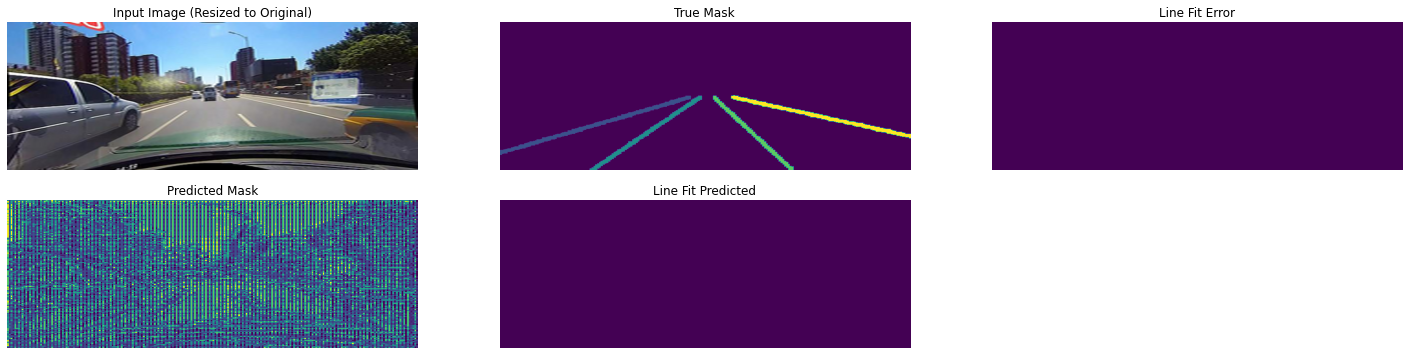

True Lane Center = -0.141 | Predicted Lane Center = nan
Line Fit Accuracy = 0.000 | Lane Center Accuracy = 0.000

Model ResNet50


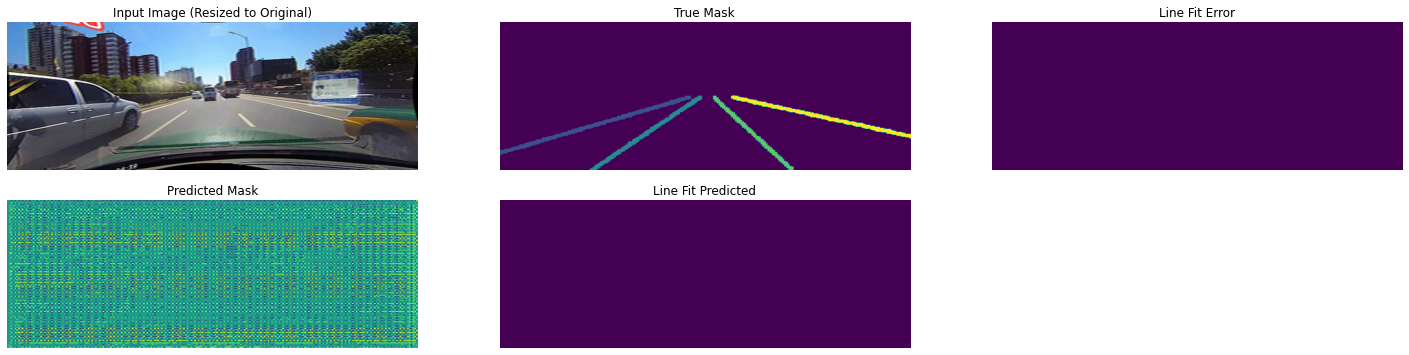

True Lane Center = -0.141 | Predicted Lane Center = nan
Line Fit Accuracy = 0.000 | Lane Center Accuracy = 0.000

Model VGG19


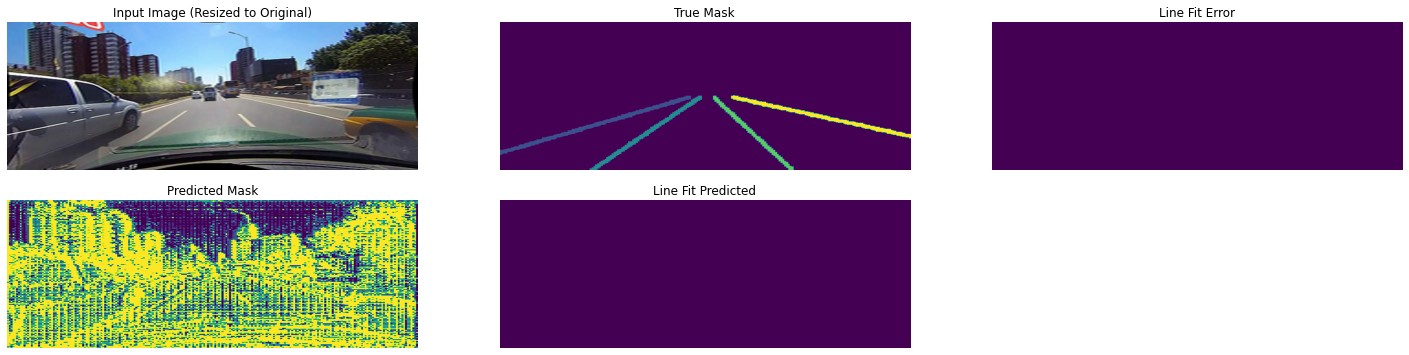

True Lane Center = -0.141 | Predicted Lane Center = nan
Line Fit Accuracy = 0.000 | Lane Center Accuracy = 0.000



In [25]:
# Test predictions for appropriate functionality before training
print('Model MobileNetV2')
display_prediction(model_mobilenetv2, sample_image, sample_mask)
print('Model ResNet50')
display_prediction(model_resnet50, sample_image, sample_mask)
print('Model VGG19')
display_prediction(model_vgg19, sample_image, sample_mask)

# Model Training

## MobileNetV2

Training Model MobileNetV2
Epoch 1/7
695/695 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9721 - mean_iou: 0.4410

Sample Prediction after epoch 1


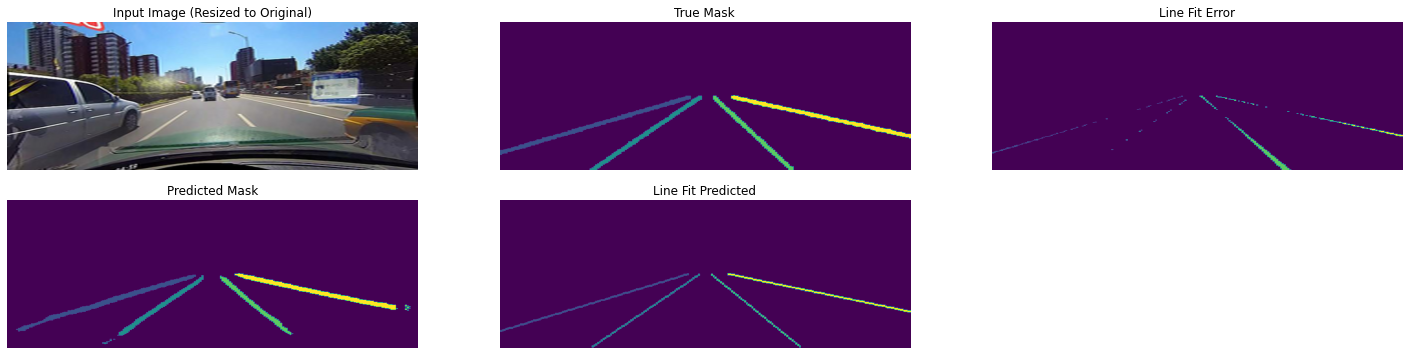

True Lane Center = -0.141 | Predicted Lane Center = -0.096
Line Fit Accuracy = 0.992 | Lane Center Accuracy = 0.977

Line Fit Accuracy - Training Dataset:  0.8664382054255568  | Validation Dataset:  0.8386740321794549
Lane Center Accuracy - Training Dataset:  0.8246777284761198  | Validation Dataset:  0.7665165021898885
695/695 [==============================] - 1762s 3s/step - loss: 0.0182 - accuracy: 0.9721 - mean_iou: 0.4410 - val_loss: 0.0159 - val_accuracy: 0.9711 - val_mean_iou: 0.4603
Epoch 2/7
695/695 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9798 - mean_iou: 0.5674

Sample Prediction after epoch 2


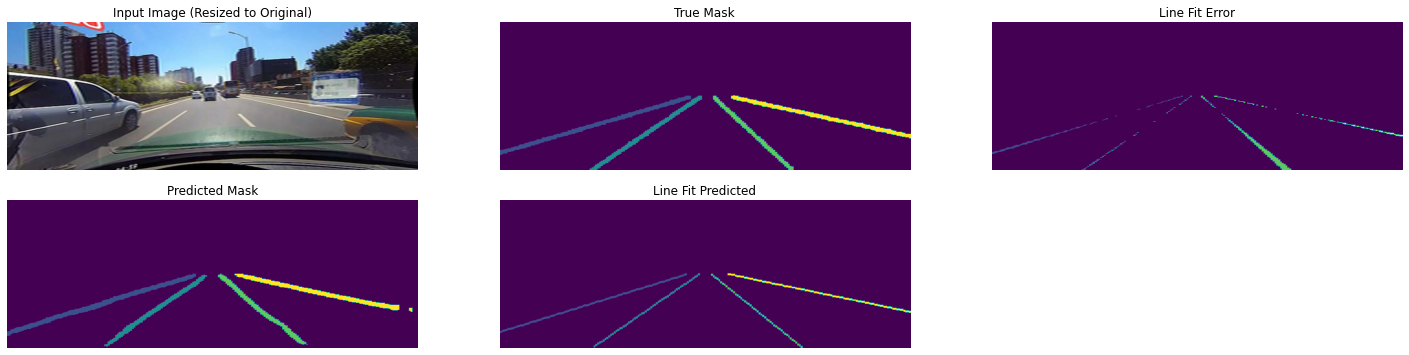

True Lane Center = -0.141 | Predicted Lane Center = -0.083
Line Fit Accuracy = 0.990 | Lane Center Accuracy = 0.971

Line Fit Accuracy - Training Dataset:  0.8935458035072323  | Validation Dataset:  0.8471443728303651
Lane Center Accuracy - Training Dataset:  0.8650195021824367  | Validation Dataset:  0.8202601360739181
695/695 [==============================] - 1722s 2s/step - loss: 0.0094 - accuracy: 0.9798 - mean_iou: 0.5674 - val_loss: 0.0156 - val_accuracy: 0.9706 - val_mean_iou: 0.4755
Epoch 3/7
695/695 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9814 - mean_iou: 0.5996

Sample Prediction after epoch 3


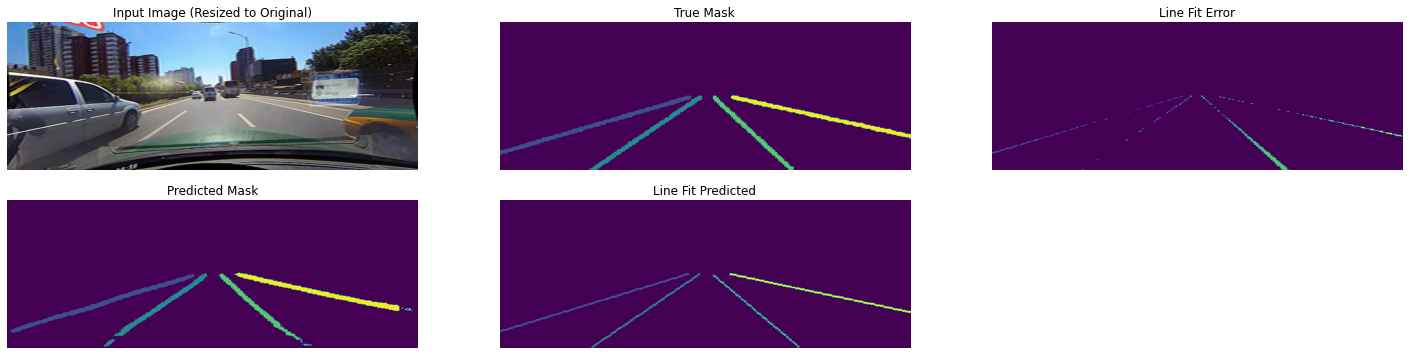

True Lane Center = -0.141 | Predicted Lane Center = -0.103
Line Fit Accuracy = 0.993 | Lane Center Accuracy = 0.981

Line Fit Accuracy - Training Dataset:  0.8891783569072447  | Validation Dataset:  0.8288215821218411
Lane Center Accuracy - Training Dataset:  0.847800121923536  | Validation Dataset:  0.7684719664945711
695/695 [==============================] - 1741s 3s/step - loss: 0.0083 - accuracy: 0.9814 - mean_iou: 0.5996 - val_loss: 0.0165 - val_accuracy: 0.9706 - val_mean_iou: 0.4729
Epoch 4/7
695/695 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9825 - mean_iou: 0.6211

Sample Prediction after epoch 4


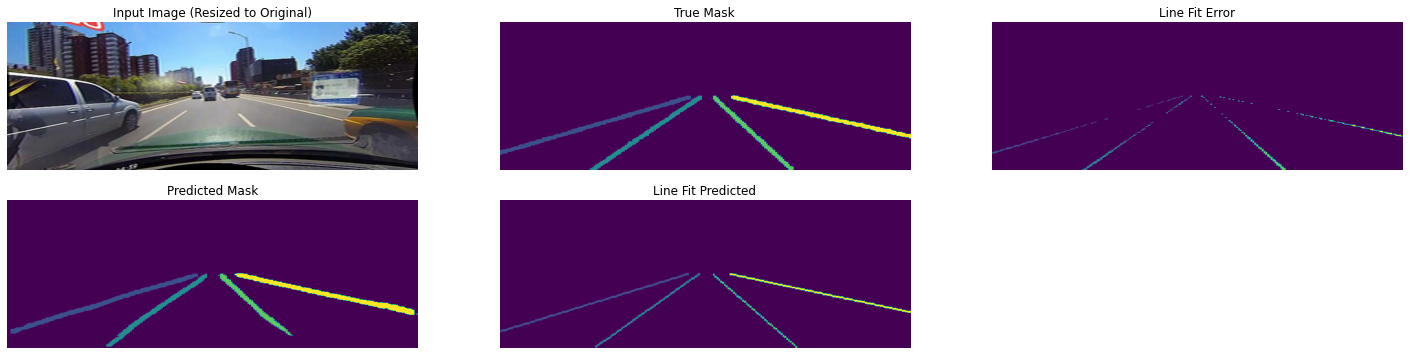

True Lane Center = -0.141 | Predicted Lane Center = -0.103
Line Fit Accuracy = 0.993 | Lane Center Accuracy = 0.981

Line Fit Accuracy - Training Dataset:  0.899360767526191  | Validation Dataset:  0.8393136840140883
Lane Center Accuracy - Training Dataset:  0.8698535050576225  | Validation Dataset:  0.790091635402851
695/695 [==============================] - 1746s 3s/step - loss: 0.0077 - accuracy: 0.9825 - mean_iou: 0.6211 - val_loss: 0.0164 - val_accuracy: 0.9703 - val_mean_iou: 0.4750
Epoch 5/7
695/695 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9833 - mean_iou: 0.6388

Sample Prediction after epoch 5


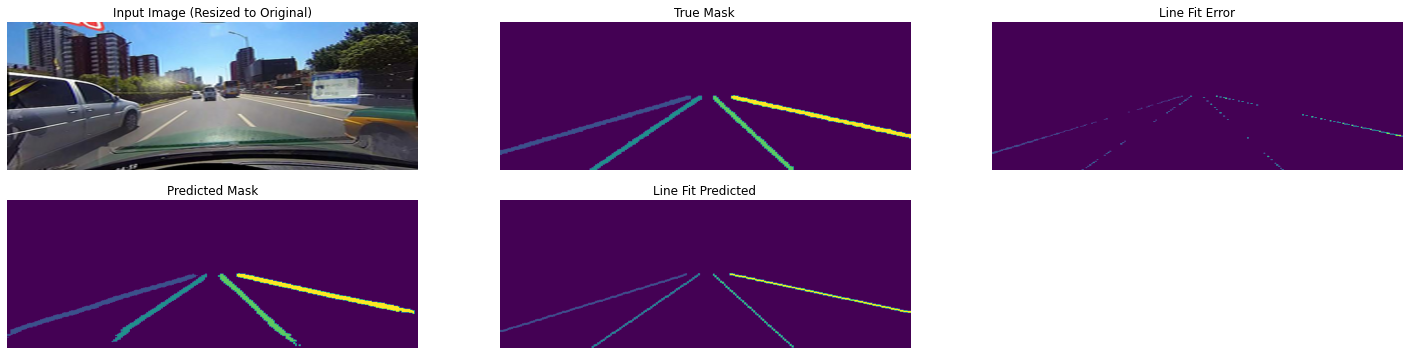

True Lane Center = -0.141 | Predicted Lane Center = -0.134
Line Fit Accuracy = 0.996 | Lane Center Accuracy = 0.996

Line Fit Accuracy - Training Dataset:  0.909824050951224  | Validation Dataset:  0.8509294867294386
Lane Center Accuracy - Training Dataset:  0.872368929306639  | Validation Dataset:  0.8135397376933974
695/695 [==============================] - 1708s 2s/step - loss: 0.0071 - accuracy: 0.9833 - mean_iou: 0.6388 - val_loss: 0.0164 - val_accuracy: 0.9703 - val_mean_iou: 0.4789
Epoch 6/7
695/695 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9840 - mean_iou: 0.6534

Sample Prediction after epoch 6


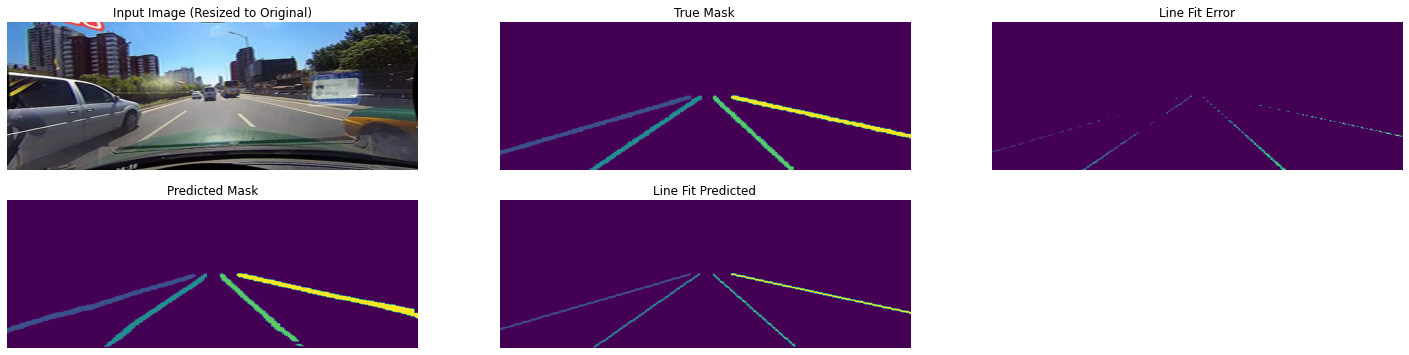

True Lane Center = -0.141 | Predicted Lane Center = -0.111
Line Fit Accuracy = 0.995 | Lane Center Accuracy = 0.985

Line Fit Accuracy - Training Dataset:  0.9138721573858123  | Validation Dataset:  0.8491119356456177
Lane Center Accuracy - Training Dataset:  0.8886895355892345  | Validation Dataset:  0.8135182556951246
695/695 [==============================] - 1725s 2s/step - loss: 0.0067 - accuracy: 0.9840 - mean_iou: 0.6534 - val_loss: 0.0173 - val_accuracy: 0.9685 - val_mean_iou: 0.4749
Epoch 7/7
695/695 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9848 - mean_iou: 0.6687

Sample Prediction after epoch 7


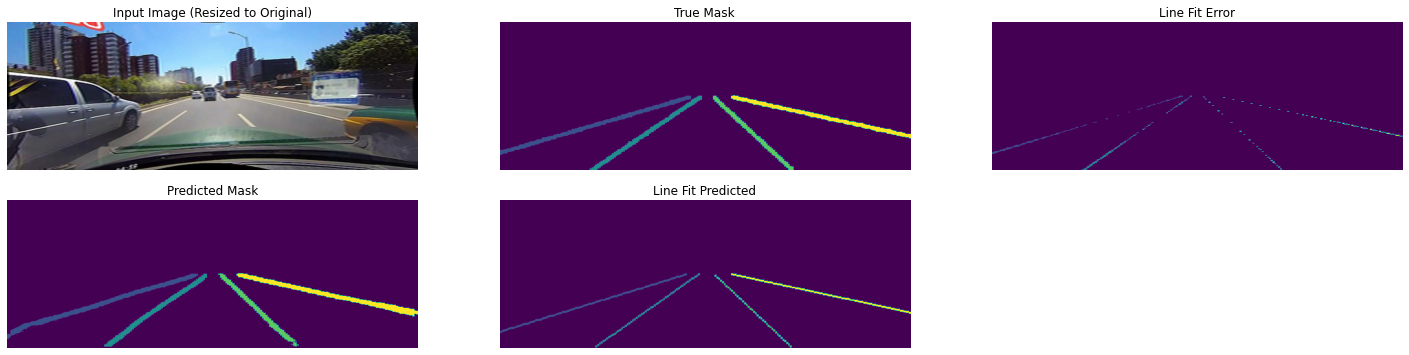

True Lane Center = -0.141 | Predicted Lane Center = -0.132
Line Fit Accuracy = 0.994 | Lane Center Accuracy = 0.995

Line Fit Accuracy - Training Dataset:  0.9165420038172287  | Validation Dataset:  0.8591146380649217
Lane Center Accuracy - Training Dataset:  0.9124876850363486  | Validation Dataset:  0.8384366840035316
695/695 [==============================] - 1729s 2s/step - loss: 0.0062 - accuracy: 0.9848 - mean_iou: 0.6687 - val_loss: 0.0174 - val_accuracy: 0.9685 - val_mean_iou: 0.4750
INFO:tensorflow:Assets written to: /content/drive/My Drive/Models_Shared/model_mobilenetv2_extra_50Data_64Batch_7Epoch/assets


In [ ]:
# Final Model Selection: MobileNetV2 with 5 layers per decoder block, trained on 50% data with batch size 64 and 7 epochs
print('Training Model MobileNetV2')
model_metrics = None
model_history = model_mobilenetv2.fit(train_batches, epochs=EPOCHS, validation_data=val_batches, callbacks=[DisplayCallback()], workers=4, use_multiprocessing=True)
save_model_and_history(model_mobilenetv2, model_history, model_metrics, 'model_mobilenetv2_extra_50Data_64Batch_7Epoch')

## ResNet50

In [ ]:
print('Training Model ResNet50')
model_metrics = None
model_history = model_resnet50.fit(train_batches, epochs=EPOCHS, validation_data=val_batches, callbacks=[DisplayCallback()], workers=4, use_multiprocessing=True)
save_model_and_history(model_resnet50, model_history, model_metrics, 'model_resnet50')

## VGG-19

In [ ]:
print('Training Model VGG19')
model_metrics = None
model_history = model_vgg19.fit(train_batches, epochs=EPOCHS, validation_data=val_batches, callbacks=[DisplayCallback()], workers=4, use_multiprocessing=True)
save_model_and_history(model_vgg19, model_history, model_metrics, 'model_vgg19')

# Model Evaluation

## Evaluation Functions

In [26]:
# Plot the training history metrics
def plot_history_metrics(hist_df, metrics_df):
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 3, 1)
  plt.title('Categorical Crossentropy Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist_df["epoch"]+1, hist_df["loss"], label="Training Dataset")
  plt.plot(hist_df["epoch"]+1, hist_df["val_loss"], label="Validation Dataset")
  plt.legend()
  plt.subplot(1, 3, 2)
  plt.title('Pixel Label Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist_df["epoch"]+1, hist_df["accuracy"], label="Training Dataset")
  plt.plot(hist_df["epoch"]+1, hist_df["val_accuracy"], label="Validation Dataset")
  plt.legend()
  plt.subplot(1, 3, 3)
  plt.title('Category Mean IoU')
  plt.xlabel('Epoch')
  plt.ylabel('Mean IoU')
  plt.plot(hist_df["epoch"]+1, hist_df["mean_iou"], label="Training Dataset")
  plt.plot(hist_df["epoch"]+1, hist_df["val_mean_iou"], label="Validation Dataset")
  plt.legend()
  plt.show()
  print()
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.title('Line Fit Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(metrics_df["epoch"]+1, metrics_df["line_fit_acc"], label="Training Dataset")
  plt.plot(metrics_df["epoch"]+1, metrics_df["val_line_fit_acc"], label="Validation Dataset")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.title('Lane Center Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(metrics_df["epoch"]+1, metrics_df["lane_center_acc"], label="Training Dataset")
  plt.plot(metrics_df["epoch"]+1, metrics_df["val_lane_center_acc"], label="Validation Dataset")
  plt.legend()
  plt.show()

# Evaluate the model by computing the metrics on the testing dataset
def evaluate_model(model):
  test_loss, test_accuracy, test_mean_iou = model.evaluate(test_batches, verbose=1, workers=4, use_multiprocessing=True)
  test_line_fit_accuracy, test_lane_center_accuracy = evaluate_model_accuracy_batches(model, test_batches)
  print('Testing Dataset Performance:')
  print('Categorical Crossentropy Loss: ', test_loss)
  print('Pixel Label Accuracy: ', test_accuracy)
  print('Category Mean IoU: ', test_mean_iou)
  print('Line Fit Accuracy: ', test_line_fit_accuracy)
  print('Lane Center Accuracy: ', test_lane_center_accuracy)

# Generate plots to compare the training history metrics between different models
def compare_plot_history_metrics(model_names, filter_text=''):
  history_df = []
  metrics_df = []
  for model_name in model_names:
    history_df.append(pd.read_csv(SAVE_FOLDER + '/' + model_name + '/history.csv'))
    metrics_df.append(pd.read_csv(SAVE_FOLDER + '/' + model_name + '/metrics.csv').drop(['epoch'], axis=1))

  model_names = pd.array(model_names)
  df = pd.concat([pd.concat(history_df,keys=model_names), pd.concat(metrics_df,keys=model_names)], axis=1)
  titles = [['Categorical Crossentropy Loss','Loss','loss'],
            ['Pixel Label Accuracy', 'Accuracy','accuracy'],
            ['Category Mean IoU','Mean IoU','mean_iou'],
            ['Line Fit Accuracy', 'Accuracy','line_fit_acc'],
            ['Lane Center Accuracy', 'Accuracy','lane_center_acc']]

  for i in range (len(titles)):
    plt.figure(figsize=(15, 5))
    plt1 = plt.subplot(1, 2, 1)
    plt.title('Training ' + titles[i][0])
    plt.xlabel('Epoch')
    plt.ylabel(titles[i][1])
    for j in range(len(model_names)):
      if (len(filter_text)>0 and model_names[j].find(filter_text) == -1):
        continue
      plt.plot(df.loc[model_names[j]][:]["epoch"]+1, df.loc[model_names[j]][:][titles[i][2]], label=model_names[j].replace('model_','').replace('_',' ').replace('extra','5LayerDecoder'))
    plt.legend()
    plt.subplot(1, 2, 2, sharey=plt1)
    plt.title('Validation ' + titles[i][0])
    plt.xlabel('Epoch')
    plt.ylabel(titles[i][1])
    for j in range(len(model_names)):
      if (len(filter_text)>0 and model_names[j].find(filter_text) == -1):
        continue
      plt.plot(df.loc[model_names[j]][:]["epoch"]+1, df.loc[model_names[j]][:]['val_' + titles[i][2]], label=model_names[j].replace('model_','').replace('_',' ').replace('extra','5LayerDecoder'))
    plt.legend()
    plt.show()
    print()

## Load Model

In [36]:
# Final Model
test_model, test_history_df, test_metrics_df = load_model_and_history('model_mobilenetv2_extra_50Data_64Batch_7Epoch')

## Training Performance

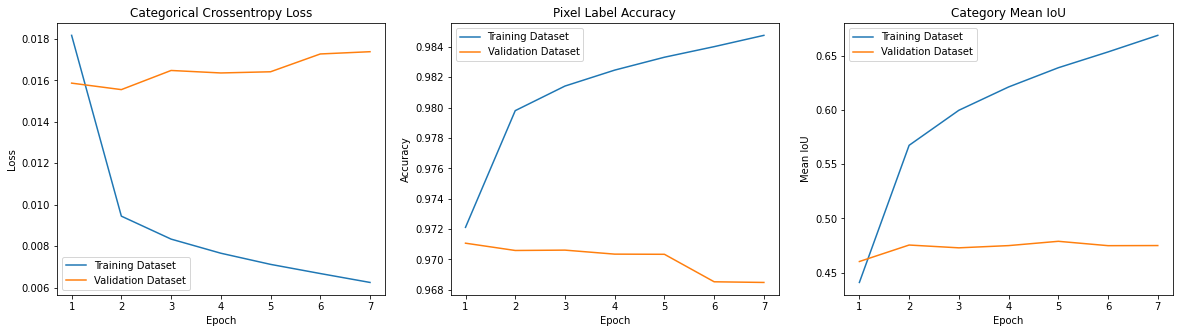

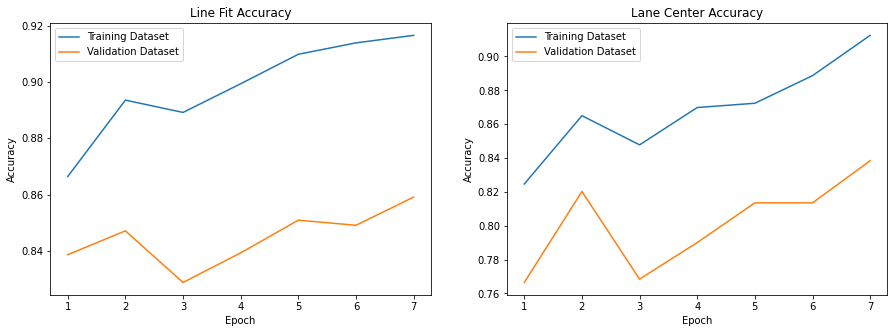

In [37]:
plot_history_metrics(test_history_df, test_metrics_df)

## Testing Performance

In [39]:
evaluate_model(test_model)

271/271 [==============================] - 348s 1s/step - loss: 0.0173 - accuracy: 0.9709 - mean_iou: 0.4524
Testing Dataset Performance:
Categorical Crossentropy Loss:  0.01733940653502941
Pixel Label Accuracy:  0.9709233045578003
Category Mean IoU:  0.4524468779563904
Line Fit Accuracy:  0.8211595460794627
Lane Center Accuracy:  0.7845017671373082


## Sample Predictions

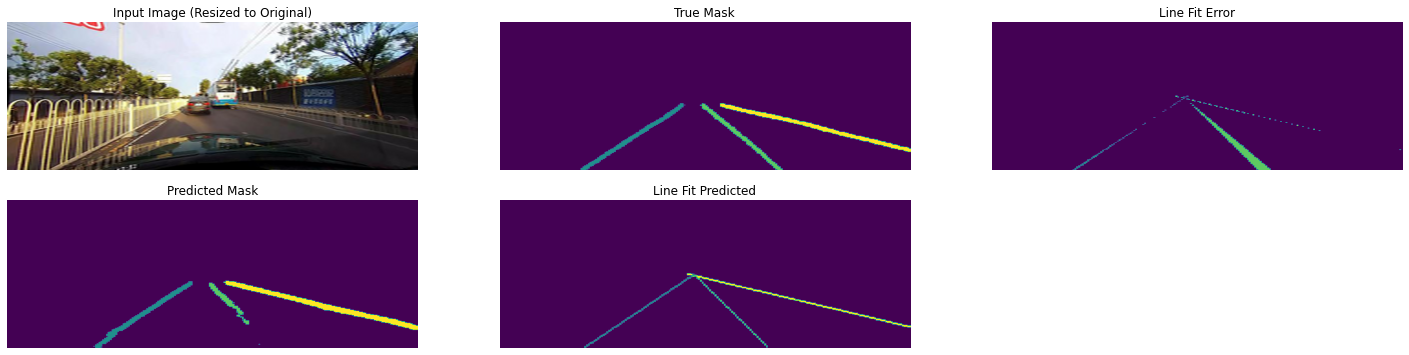

True Lane Center = -0.247 | Predicted Lane Center = -0.327
Line Fit Accuracy = 0.990 | Lane Center Accuracy = 0.960



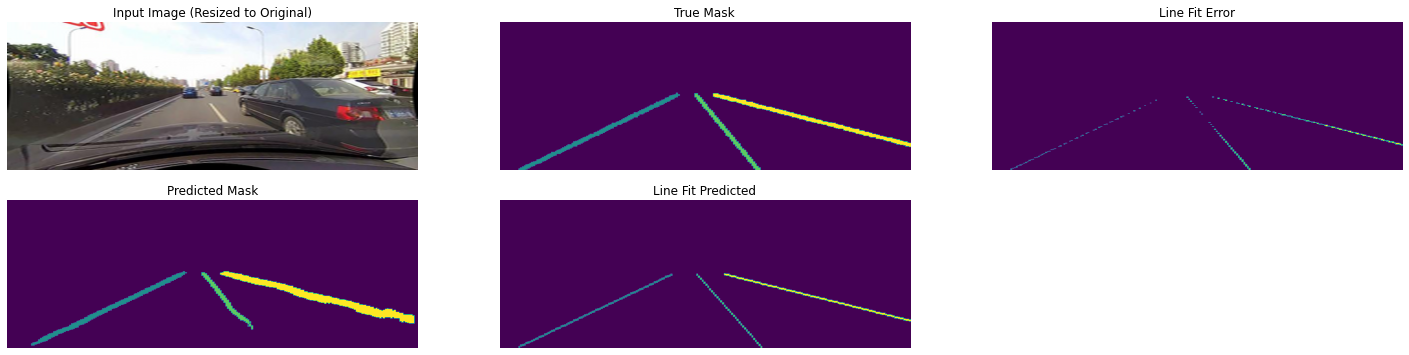

True Lane Center = -0.561 | Predicted Lane Center = -0.546
Line Fit Accuracy = 0.995 | Lane Center Accuracy = 0.993



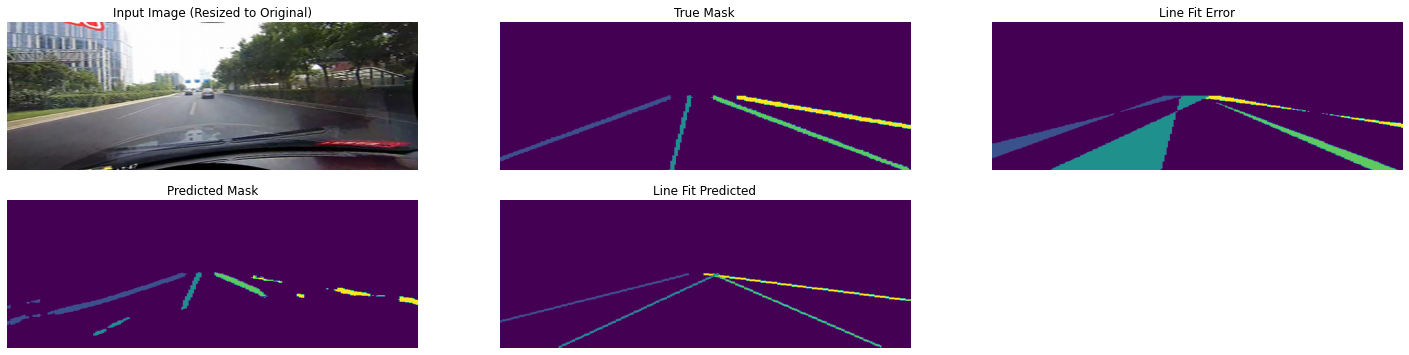

True Lane Center = 0.704 | Predicted Lane Center = 0.088
Line Fit Accuracy = 0.901 | Lane Center Accuracy = 0.692



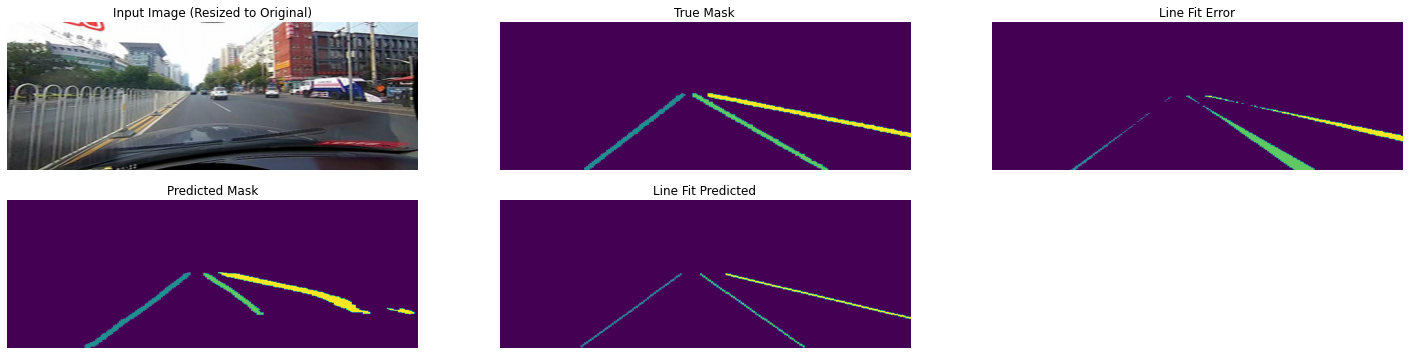

True Lane Center = -0.006 | Predicted Lane Center = -0.123
Line Fit Accuracy = 0.977 | Lane Center Accuracy = 0.941



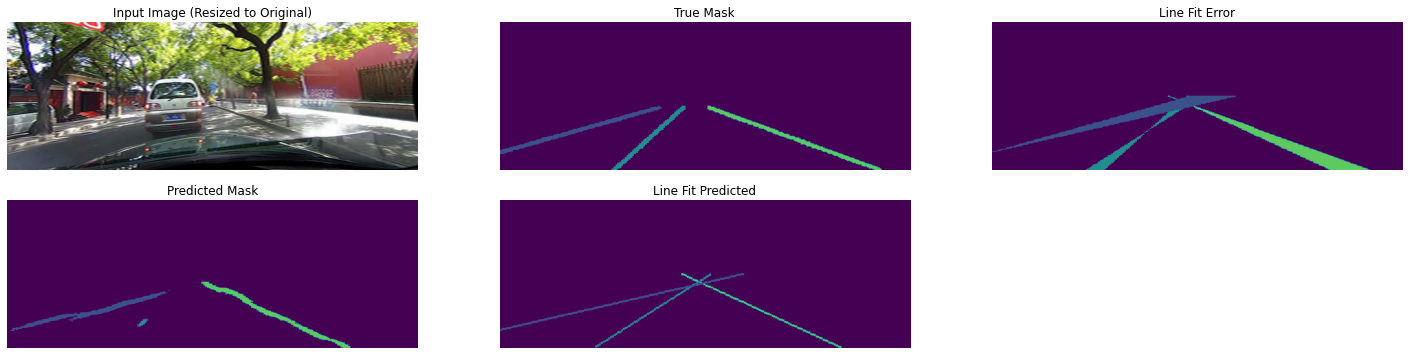

True Lane Center = 0.306 | Predicted Lane Center = 0.094
Line Fit Accuracy = 0.943 | Lane Center Accuracy = 0.894



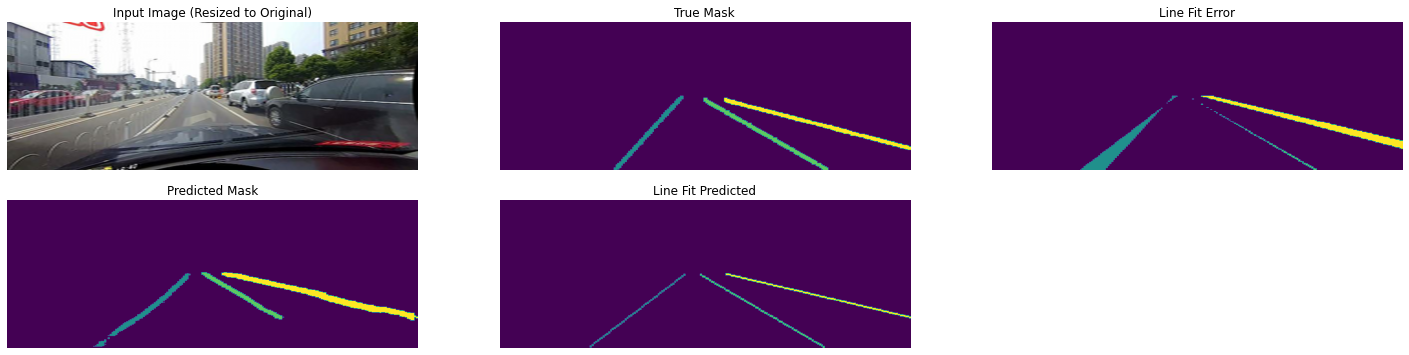

True Lane Center = 0.141 | Predicted Lane Center = 0.005
Line Fit Accuracy = 0.966 | Lane Center Accuracy = 0.932



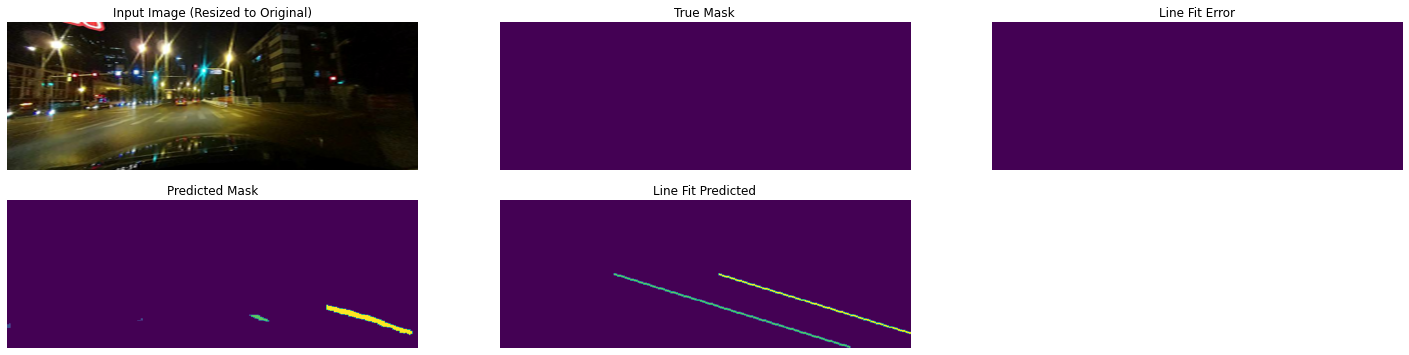

True Lane Center = nan | Predicted Lane Center = nan
Line Fit Accuracy = 0.500 | Lane Center Accuracy = 1.000



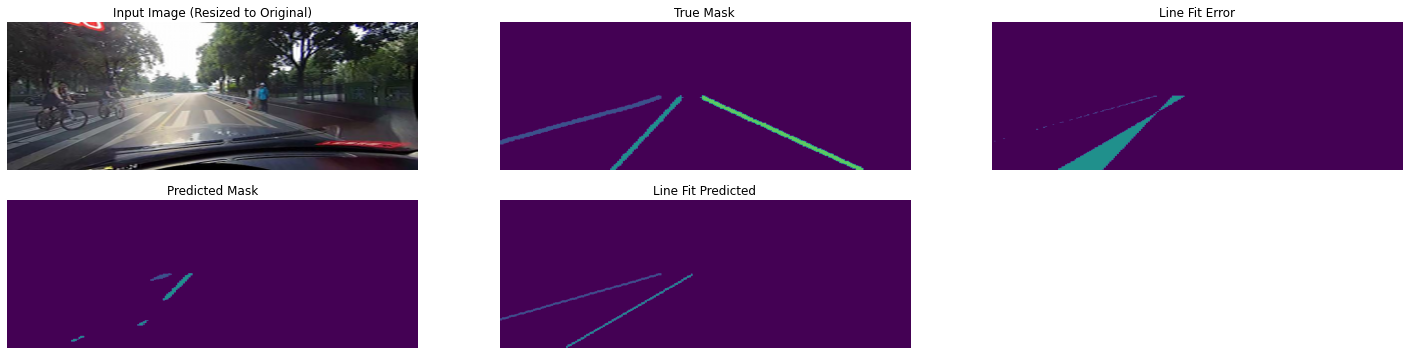

True Lane Center = 0.248 | Predicted Lane Center = nan
Line Fit Accuracy = 0.726 | Lane Center Accuracy = 0.000



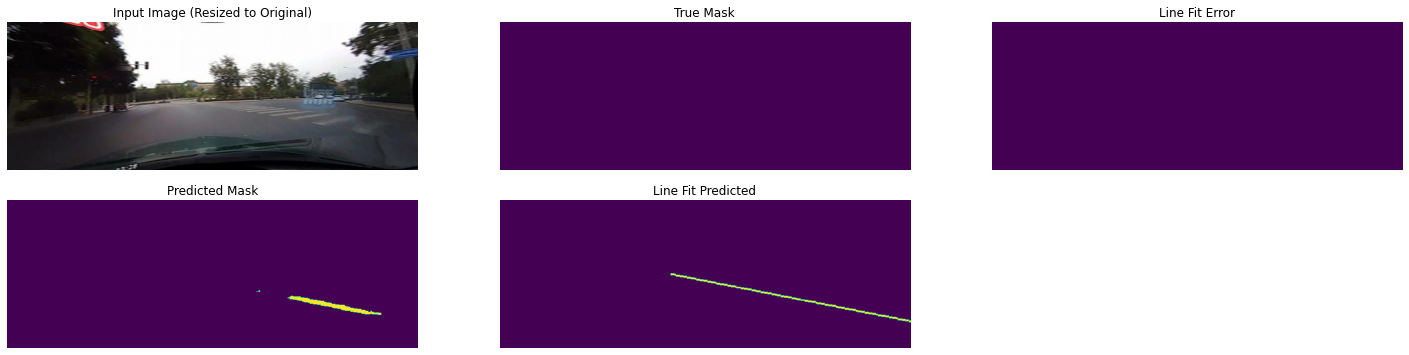

True Lane Center = nan | Predicted Lane Center = nan
Line Fit Accuracy = 0.750 | Lane Center Accuracy = 1.000



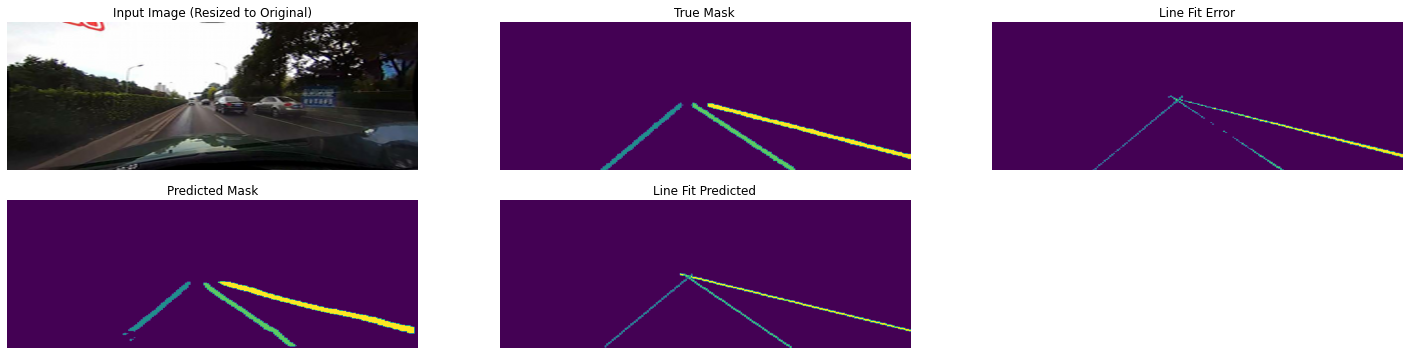

True Lane Center = -0.083 | Predicted Lane Center = -0.096
Line Fit Accuracy = 0.989 | Lane Center Accuracy = 0.994



In [38]:
for image, mask, weights in test_ds.skip(100).take(10):
  display_prediction(test_model, image, mask)

## Model Comparison

Base Model Comparison


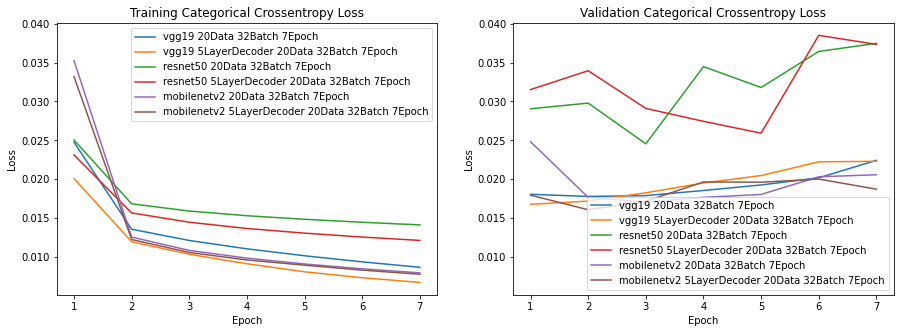

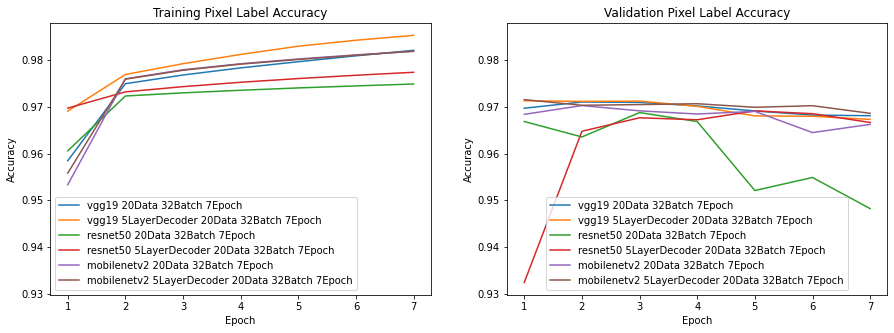

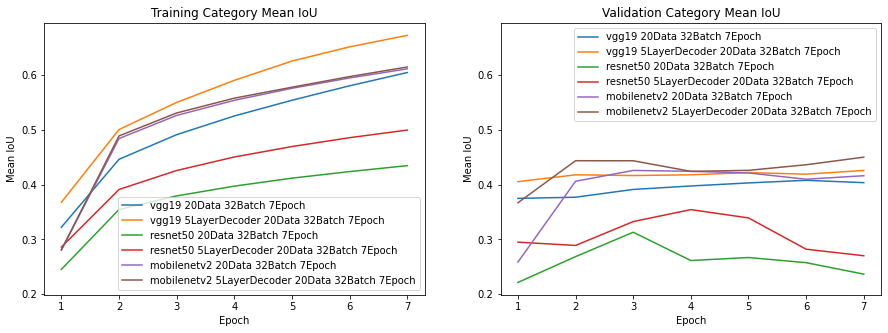

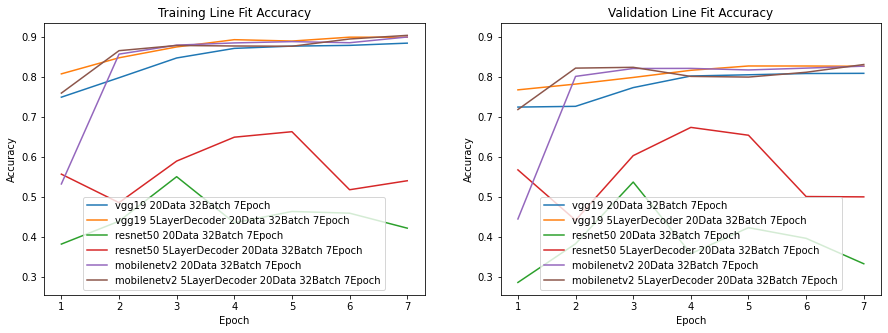

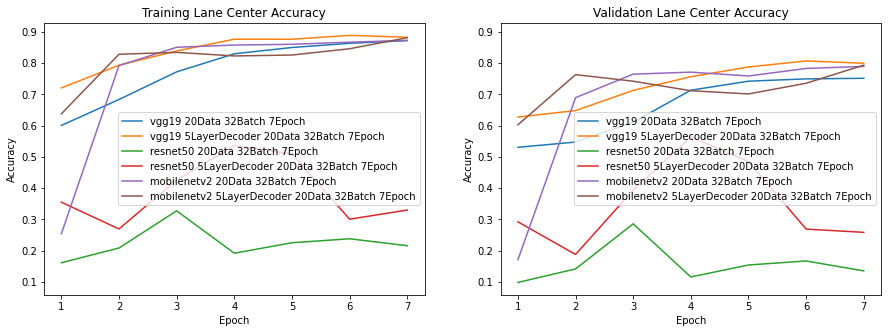



MobileNetV2 Model Comparison


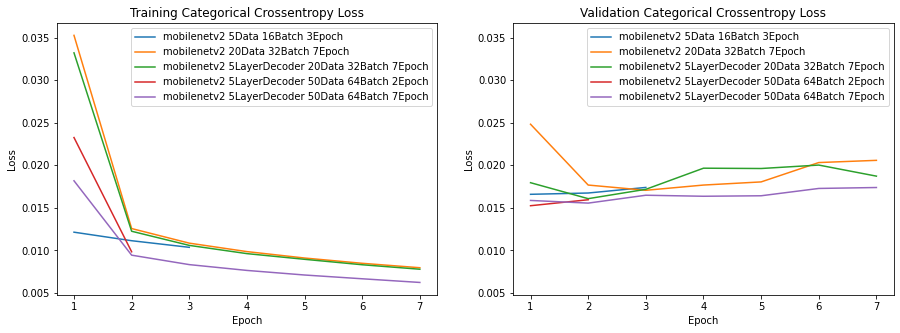

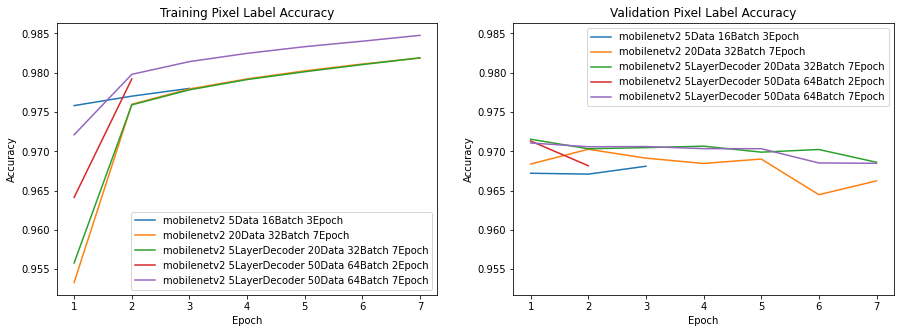

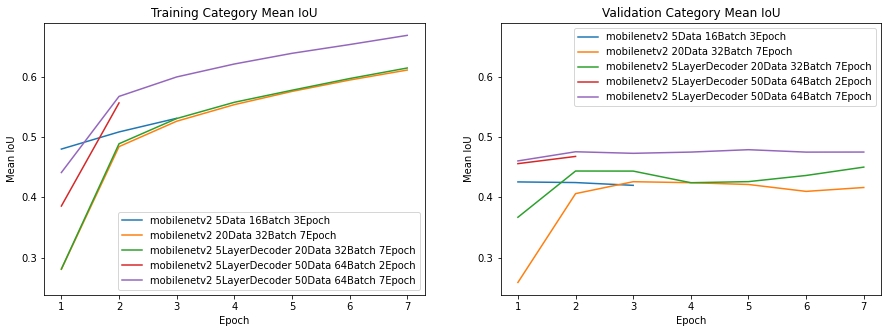

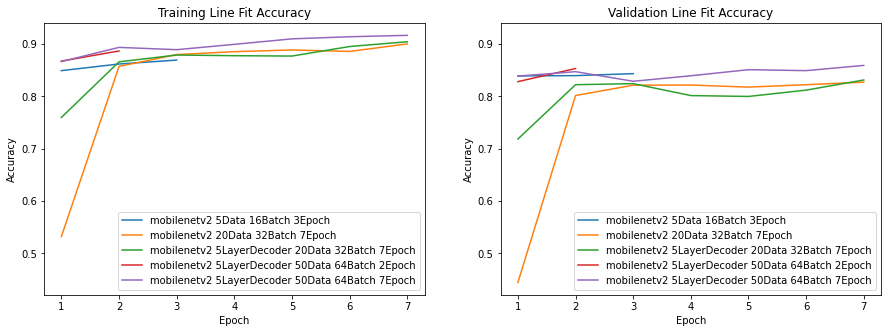

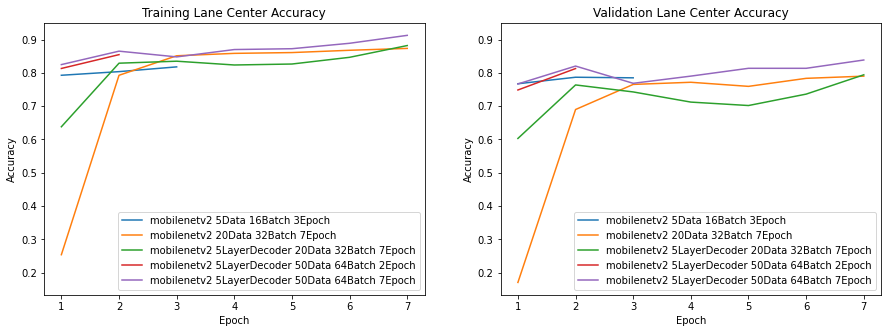

In [33]:
model_names = ['model_vgg19_5Data_16Batch_3Epoch', 
              'model_vgg19_20Data_32Batch_7Epoch', 
              'model_vgg19_extra_20Data_32Batch_7Epoch',
              'model_resnet50_5Data_16Batch_3Epoch',
              'model_resnet50_20Data_32Batch_7Epoch',
              'model_resnet50_extra_20Data_32Batch_7Epoch',
              'model_mobilenetv2_5Data_16Batch_3Epoch',
              'model_mobilenetv2_20Data_32Batch_7Epoch', 
              'model_mobilenetv2_extra_20Data_32Batch_7Epoch',
              'model_mobilenetv2_extra_50Data_64Batch_2Epoch',
              'model_mobilenetv2_extra_50Data_64Batch_7Epoch']

print("Base Model Comparison")
compare_plot_history_metrics(model_names,'32Batch')
print()
print("MobileNetV2 Model Comparison")
compare_plot_history_metrics(model_names,'mobile')